In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans

import pickle

In [38]:
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style('whitegrid')

In [3]:
# CENSUS_PATH = 'data/refined/census_data.parquet'

# CUSTOMER_PATH = 'data/refined/customer_data.parquet'

In [1]:
CENSUS_PATH = 'data/refined/full_census_data.parquet'

CUSTOMER_PATH = 'data/refined/full_customer_data.parquet'

In [4]:
census = pd.read_parquet(CENSUS_PATH)

In [5]:
census.head()

,LNR,AGER_TYP,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,...,SEMIO_VERT,SHOPPER_TYP,TITEL_KZ,VERS_TYP,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
1,910220,2.0,18.0,11.834014,13.46175,14.515307,15.114754,11.0,0.0,0.0,...,1,3.0,1.0,2.0,3.0,9.0,4.0,5,2,1
2,910225,2.0,17.0,11.834014,13.46175,14.515307,15.114754,10.0,0.0,0.0,...,4,2.0,1.0,1.0,3.0,9.0,2.0,5,2,3
3,910226,2.0,13.0,11.834014,13.46175,14.515307,15.114754,1.0,0.0,0.0,...,4,1.0,1.0,1.0,6.0,9.0,7.0,3,2,4
4,910241,2.0,20.0,11.834014,13.46175,14.515307,15.114754,3.0,0.0,0.0,...,7,2.0,1.0,2.0,2.0,9.0,3.0,4,1,3
5,910244,3.0,10.0,11.834014,13.46175,14.515307,15.114754,5.0,0.0,0.0,...,2,0.0,1.0,2.0,6.0,9.0,7.0,4,2,1


In [9]:
census_var_types = pd.read_excel('data/raw/DIAS Attributes - Values 2017.xlsx', sheet_name='Tabelle1_fixed', usecols='B:C', header=1)

census_var_types.dropna(inplace = True)

In [11]:
census_var_types.loc[census_var_types['Attribute'] == 'ANZ_HH_TITEL','Type'] = 'binary'

In [12]:
census.shape

(737494, 311)

In [13]:
census_var_types['Type'].value_counts()

interval    300
nominal      19
numeric      11
binary        8
Name: Type, dtype: int64

Variables considered as interval could be used in PCA. Unfortunately, this approach is not enough to handle nominal and binary features.  
An alteranitve approach to solve this problem is [Factorial Analysis of Mixed Data (FAMD)](https://towardsdatascience.com/famd-how-to-generalize-pca-to-categorical-and-numerical-data-2ddbeb2b9210).  
Using this approach, we will reduce the dimensions of the mixed data types prior to clustering it.

# Clustering demographic data

## Adjustments to nominals and binaries

In [14]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [15]:
for col in binary_vars:
    
    try:
        print(col, census[col].unique())

    except:

        print(f'Column not found: {col}')

        continue

ANREDE_KZ [2 1]
ANZ_HH_TITEL [0. 1.]
GREEN_AVANTGARDE [0 1]
KBA05_SEG6 [1. 0.]
OST_WEST_KZ [1. 0.]
VERS_TYP [2. 1.]


In [16]:
census['ANREDE_KZ'] = census['ANREDE_KZ'] - 1

census['VERS_TYP'] = census['VERS_TYP'] - 1

## Subsetting dataframe

In [14]:
# is_subset = True

# if is_subset:

#     with open('data/trusted/selected_features.pkl', 'rb') as file:

#         selected_features = pickle.load(file)
    
#     selected_features.append('LNR')

#     census = census[selected_features].copy()

In [17]:
nominal_vars = census_var_types[census_var_types['Type'] == 'nominal']['Attribute'].values

nominal_vars = np.intersect1d(nominal_vars, census.columns)

In [18]:
interval_vars = census_var_types[census_var_types['Type'] == 'interval']['Attribute'].values

interval_vars = np.intersect1d(interval_vars, census.columns)

In [19]:
binary_vars = census_var_types[census_var_types['Type'] == 'binary']['Attribute'].values

binary_vars = np.intersect1d(binary_vars, census.columns)

In [20]:
num_cols = census.columns.drop(list(nominal_vars) + list(binary_vars) + list(interval_vars) + ['LNR'])

In [21]:
assert (len(nominal_vars) + len(binary_vars) + len(interval_vars) + len(num_cols) + 1) == census.shape[1]

# PCA + KMeans
- FAMD Implementation
- Using K-Means so we can leverage the centroid position to predict the populations' clusters without necessarily having to cluster the whole population

In [22]:
census = pd.get_dummies(census, columns=list(nominal_vars))

In [23]:
dummy_nominal_vars = []

for name in list(nominal_vars):

    for col in census.columns:

        if name in col:

            dummy_nominal_vars.append(col)

# Fix for GEBAEUDETYP and GEBAUDETYP_RASTER
dummy_nominal_vars = sorted(list(set(dummy_nominal_vars)))

In [24]:
def weight_encoded_col(col):

    '''
    Generates weights according to FAMD implementation. Works in binary variables.
    The weight is given as the division of the 1 values by the square-root of the probability of occurance of the effect in the column.

    :param col: column to be adjusted

    :return col: column after adjustments
    '''

    # mean = probability of occurance for a binary col
    mean = col.mean()

    weight = np.sqrt(mean)

    col = col / weight
    
    # Centering
    center_ref = col.mean()

    col = col - center_ref
    
    return col

In [25]:
for col in list(binary_vars) + list(dummy_nominal_vars):

    census[col] = weight_encoded_col(census[col])

## Numerical columns

In [26]:
num_col_list = census.columns.drop(list(binary_vars) + dummy_nominal_vars + ['LNR'])

In [27]:
scaler = StandardScaler()

In [28]:
census[num_col_list] = scaler.fit_transform(census[num_col_list])

# PCA

In [29]:
census.shape

(737494, 413)

**Warning: Running the cell below might take a while. Beware of that**

In [30]:
explained_var_list_step_2 = []

for comp in range(200,350, 50):

    print(f'Running for {comp} components...')
    pca = PCA(n_components=comp, random_state=123)

    pca.fit(census.drop(columns = 'LNR'))

    expl_variance = pca.explained_variance_ratio_.sum()

    print(f'Explained Variance: {expl_variance}', end = '\n\n')
    
    explained_var_list_step_2.append(expl_variance)

    if expl_variance >= 0.95:

        break
    # explained_var_list.append(explained_var_list_step_2)

Running for 200 components...
Explained Variance: 0.8565111987215395

Running for 250 components...
Explained Variance: 0.9279100234525915

Running for 300 components...
Explained Variance: 0.9704484173211994



# K-Means

800k entries is too much for some machines to handle and/or take a long time for the algorithm to run.  
Therefore, assuming the AZDIAS data as the population we want to model for, we will use a sample of it to find the centroids of our clusters to then propagate this information.  
Using a simple [Sample Size Calculator](https://www.calculator.net/sample-size-calculator.html?type=1&cl=99.9&ci=1&pp=50&ps=891221&x=0&y=0), assuming a homogenous population we can find that starting from 5000 random samples we can have a good enough representation of the general population.

In [31]:
def score_kmeans(X,k_range):

    '''
    Function that iteratively scores K-Means based on point distance to centroids.

    :param X: Data that the Kmeans should be fitted to
    :param k_range: range to be used for experimentation.

    :return dist_list: List of total inertia for each step in the ranges
    '''

    for i, k in enumerate(k_range):

        print(f'Running for K = {k} Clusters...')

        # Using MiniBatch for performance
        kmeans = MiniBatchKMeans(n_clusters=k,
                                    init = 'k-means++',
                                    random_state=123,
                                    batch_size=2048,
                                    max_iter=50,
                                    n_init = 3)

        kmeans.fit(X)

        if i == 0:

            dist_list = [kmeans.inertia_]
        
        else:

            dist_list.append(kmeans.inertia_)

    return dist_list

In [32]:
pca = PCA(n_components=275, random_state=123)

pca.fit(census.drop(columns = 'LNR'))

X = pca.transform(census.drop(columns = 'LNR'))

In [33]:
rng = np.random.default_rng()

# Reproducibility
np.random.seed = 123

X_sample = rng.choice(X, size = 20000, replace = False)

In [42]:
k_range = range(2,21)

In [43]:
distances = score_kmeans(X_sample, k_range)

Running for K = 2 Clusters...
Running for K = 3 Clusters...
Running for K = 4 Clusters...
Running for K = 5 Clusters...
Running for K = 6 Clusters...
Running for K = 7 Clusters...
Running for K = 8 Clusters...
Running for K = 9 Clusters...
Running for K = 10 Clusters...
Running for K = 11 Clusters...
Running for K = 12 Clusters...
Running for K = 13 Clusters...
Running for K = 14 Clusters...
Running for K = 15 Clusters...
Running for K = 16 Clusters...
Running for K = 17 Clusters...
Running for K = 18 Clusters...
Running for K = 19 Clusters...
Running for K = 20 Clusters...


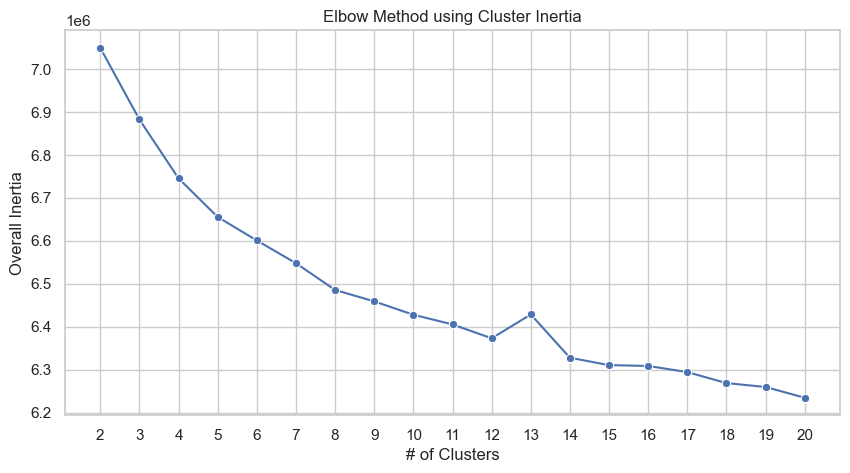

In [45]:
sns.lineplot(x = range(2,len(distances) + 2),
             y = distances,
             marker = 'o')

plt.xlabel('# of Clusters')

plt.xticks(ticks = range(2,21))

plt.ylabel('Overall Inertia')

plt.title('Elbow Method using Cluster Inertia')

plt.show()

Using the Elbow Method we can choose 12 as an appropriate number of clusters

## Instantiating selected clustering method

In [46]:
kmeans_model = MiniBatchKMeans(n_clusters=12,
                                init = 'k-means++',
                                random_state=123,
                                batch_size=2048,
                                max_iter=50,
                                n_init = 3)

kmeans_model.fit(X_sample)

MiniBatchKMeans(batch_size=2048, max_iter=50, n_clusters=12, n_init=3,
                random_state=123)

In [47]:
# with open('models/demographic_clusters.pkl','wb') as file:

#     pickle.dump(kmeans_model, file)

# Comparing Datasets

## Customer data Preprocessing

In [54]:
customers = pd.read_parquet(CUSTOMER_PATH)

In [55]:
# Preprocessing customers data like we did census data
customers = pd.get_dummies(customers, columns=list(nominal_vars))

for col in list(binary_vars) + list(dummy_nominal_vars):
    try:
        customers[col] = weight_encoded_col(customers[col])
    except:
        
        print('Category Not Found:',col)
        
        customers[col] = 0
        
        continue

customers[num_col_list] = scaler.fit_transform(customers[num_col_list])

Category Not Found: GEBAEUDETYP_5.0


C:\Users\Lucca\AppData\Local\Temp\ipykernel_10272\3512993594.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers[col] = 0


Category Not Found: TITEL_KZ_2.0


C:\Users\Lucca\AppData\Local\Temp\ipykernel_10272\3512993594.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  customers[col] = 0


In [59]:
X_cust = pca.transform(customers[census.columns].drop(columns = ['LNR']))

In [60]:
customers['cluster'] = kmeans_model.predict(X_cust)

In [61]:
census['cluster'] = kmeans_model.predict(X)

C:\Users\Lucca\AppData\Local\Temp\ipykernel_10272\1116290004.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  census['cluster'] = kmeans_model.predict(X)


## Plotting Comparison

In [62]:
cluster_prop_plot = pd.concat([customers['cluster'].value_counts(normalize = True),
                                census['cluster'].value_counts(normalize = True)],
                                axis = 1)

cluster_prop_plot.columns = ['customers','azdias']

cluster_prop_plot = cluster_prop_plot.melt(ignore_index=False)

cluster_prop_plot.reset_index(inplace = True)

# cluster_prop_plot

In [63]:
import matplotlib.ticker as mtick

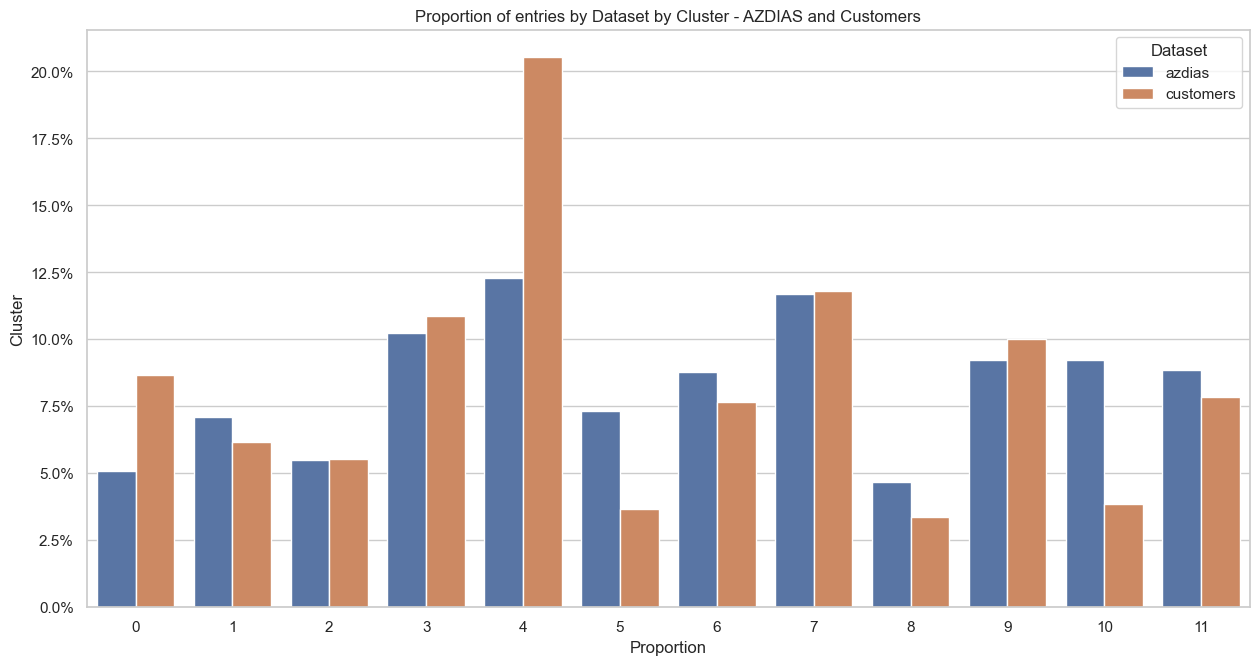

In [64]:
fig, ax = plt.subplots(figsize = (15,7.5))

g = sns.barplot(
                    data = cluster_prop_plot,
                    x = 'index',
                    y = 'value',
                    hue = 'variable',
                    hue_order=['azdias','customers'],
                    ax = ax
                )

g.yaxis.set_major_formatter(mtick.PercentFormatter(xmax = 1))

plt.title('Proportion of entries by Dataset by Cluster - AZDIAS and Customers')

plt.xlabel('Proportion')

plt.ylabel('Cluster')

plt.legend(title = 'Dataset')

plt.show()

As we can see from the plot. It looks like the clusters 0, 3, 4 and 9 are those who concentrate more customers profile. People that are assigned in those clusters are more likely to turn into potential leads.  

Let's dig a little deeper on the 4 cluster since it is the cluster that contains the most entries for customer data

## Cluster interpretations

In [65]:
def get_main_components(cluster_model = kmeans_model, n_largest = 5, cluster_id = 0, return_frame = False):

    '''
    Lists main components for a given cluster in 'cluster_id' in a given model. A main component is considered a component that is centered away from 0 in either direction (positive or negative).
    Defaults to the 5 largest distances from 0.
    To work, the clustering method needs to have distance-based centroids.

    :param cluster_model: Clustering model (WITH CENTROIDS) to be evaluated for components.
    :param n_largest: Number of components to return for a cluster
    :param cluster_id: Id (index) of the cluster
    :param return_frame: Boolean to define if whole dataframe needs to be returned.
    
    :return temp: Full dataframe with components' coordinates
    :return main_components: Frame with only the n_largest defined amount of componets
    '''

    temp = pd.DataFrame(cluster_model.cluster_centers_[cluster_id],
                        columns=['component_coordinate'])
    
    temp['abs_comp_coordinate'] = temp['component_coordinate'].abs()

    if return_frame:

        return temp
    
    else:

        main_components = temp.nlargest(columns = 'abs_comp_coordinate', n = n_largest)

    return main_components

def describe_component(component_id, base_df = census, n_features = 10, pca_object = pca, return_frame = False):

    '''
    Describes a component within the PCA. Defaults to the 10 features with largest ABSOLUTE indices.

    :param component_id: Id (index) of the component
    :param base_df: Frame with the column names used in the PCA
    :param n_features: Amount of features to be extracted - Defaults to 10
    :param pca_object: PCA fitted on the base_df
    :param return_frame: Boolean that indicates if the whole variable list of indices should be returned

    :return weights_frame: Complete frame with all indices by variable:
    :return weights_frame.nlargest: Frame subsetted to only n biggest absolute indices
    '''

    base_dict = dict(zip(base_df.columns.drop('cluster'),
                         pca.components_[component_id]))
    
    weights_frame = pd.DataFrame.from_dict(base_dict, orient = 'index', columns = ['pca_weight'])

    if return_frame:

        return weights_frame
    
    else:

        weights_frame['abs_pca_weight'] = weights_frame['pca_weight'].abs()

        return weights_frame.nlargest(n_features, columns = 'abs_pca_weight')

In [66]:
main_comps = get_main_components(cluster_id=4)

print(f'Cluster 4 main components:')

display(main_comps)

Cluster 4 main components:


,component_coordinate,abs_comp_coordinate
1,-3.730538,3.730538
3,-2.290869,2.290869
2,-1.474709,1.474709
4,-0.895588,0.895588
0,0.774478,0.774478


In [67]:
for comp in [1,3,2]:

    print(f'Top 10 Main features for Component {comp}:')
    
    temp = describe_component(component_id = comp)

    display(temp.style.background_gradient(subset = 'pca_weight'))

    print(end = '\n\n')

Top 10 Main features for Component 1:


,pca_weight,abs_pca_weight
PLZ8_HHZ,0.156135,0.156135
FINANZ_MINIMALIST,0.155006,0.155006
CJT_TYP_1,0.154158,0.154158
CJT_KATALOGNUTZER,0.151975,0.151975
MOBI_REGIO,0.151665,0.151665
CJT_TYP_4,-0.146956,0.146956
FINANZ_UNAUFFAELLIGER,-0.146919,0.146919
CJT_TYP_3,-0.142232,0.142232
EWDICHTE,0.138111,0.138111
CJT_TYP_5,-0.138082,0.138082




Top 10 Main features for Component 3:


,pca_weight,abs_pca_weight
D19_WEIN_FEINKOST_RZ,0.149511,0.149511
ONLINE_AFFINITAET,0.146013,0.146013
EWDICHTE,-0.139229,0.139229
PLZ8_ANTG2,0.137778,0.137778
KBA13_AUDI,-0.135928,0.135928
PLZ8_ANTG3,0.134713,0.134713
PLZ8_ANTG4,0.130759,0.130759
OST_WEST_KZ,-0.130043,0.130043
KBA13_ALTERHALTER_45,-0.123191,0.123191
HH_EINKOMMEN_SCORE,-0.122740,0.122740




Top 10 Main features for Component 2:


,pca_weight,abs_pca_weight
KBA13_HERST_AUDI_VW,0.182218,0.182218
KBA13_SEG_MITTELKLASSE,0.158976,0.158976
KBA13_MAZDA,0.155617,0.155617
KBA13_BJ_2009,0.151371,0.151371
KBA13_SITZE_4,-0.146659,0.146659
KBA13_SEG_WOHNMOBILE,0.140695,0.140695
KBA13_SEG_SONSTIGE,0.135921,0.135921
KBA13_SEG_KLEINST,-0.134127,0.134127
KBA05_GBZ,0.130219,0.130219
KBA13_KMH_0_140,-0.128685,0.128685


Component 0:
- is heavily centered around Customer Journey definitions. Even within customer journeys, it segments the population.  
- Has a strong relationship to "dutyfull traditional minded" persons (SEMIO_PFLICHT)
- Has a strong relationship to the dominating movement in a persons youth (PRAEGENDE_JUGENDJAHRE)
- Focuses on Moneysavers that are not necessairly prepared (FINANZ_SPARER - positive sign and FINANZ_VORSORGER - negative sign)

**Component 0 can be understood as a component that describes the general consumption journey of different generations and their financial decisions**

Component 1:
- Heavily influenced by transaction activity (_DATUM and _ANZ cols)
- Considers the person online affinty (ONLINE_AFFINITAET and _QUOTE cols)
- Considers the persons life-phase (LP_LEBENSPHASE_GROB)
- Focuses on modern consumers (D19_KONSUMTYP_6.0) that are ad enthusiasts byt don't show cross-channel adherence (CJT_GESAMTTYP_6.0)

**Component 1 can be seen as a component that quantifies the consumpion patterns especially for modern consumers**